In [1]:
import transformers
from datasets import load_dataset, load_metric

medium_datasets = load_dataset("csv", data_files="medium_articles.csv")



/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

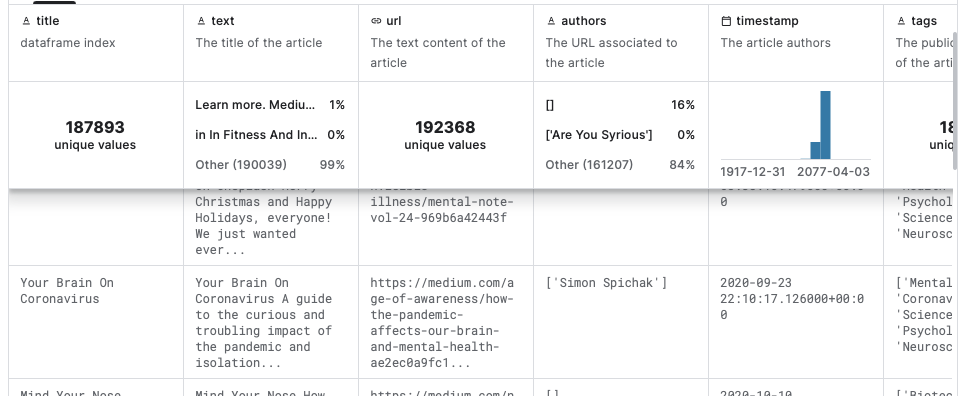

In [2]:
datasets_train_test = medium_datasets["train"].train_test_split(test_size=3000)
datasets_train_validation = datasets_train_test["train"].train_test_split(test_size=3000)

medium_datasets["train"] = datasets_train_validation["train"]
medium_datasets["validation"] = datasets_train_validation["test"]
medium_datasets["test"] = datasets_train_test["test"]
medium_datasets["train"] = medium_datasets["train"].shuffle().select(range(100000))
medium_datasets["validation"] = medium_datasets["validation"].shuffle().select(range(1000))
medium_datasets["test"] = medium_datasets["test"].shuffle().select(range(1000))

In [3]:

import nltk
nltk.download('punkt')
import string
from transformers import AutoTokenizer

model_checkpoint = "/Users/dongunyun/study/datascience/encoder_decoder/t5-base-korean-text-summary"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
medium_datasets_cleaned = medium_datasets.filter(
    lambda example: (len(example['text']) >= 500) and
    (len(example['title']) >= 20)
)

[nltk_data] Downloading package punkt to /Users/dongunyun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Filter:   0%|          | 0/100000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:

prefix = "summarize: "
max_input_length = 1024
max_target_length = 512

def clean_text(text):
    sentences = nltk.sent_tokenize(text.strip())
    sentences_cleaned = [s for sent in sentences for s in sent.split("\n")]
    sentences_cleaned_no_titles = [sent for sent in sentences_cleaned
                                    if len(sent) > 0 and
                                    sent[-1] in string.punctuation]
    text_cleaned = "\n".join(sentences_cleaned_no_titles)
    return text_cleaned

def preprocess_data(examples):
    texts_cleaned = [clean_text(text) for text in examples["text"]]
    inputs = [prefix + text for text in texts_cleaned]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["title"], max_length=max_target_length, 
                        truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [5]:
tokenized_datasets = medium_datasets_cleaned.map(preprocess_data,
                                                 batched=True)

Map:   0%|          | 0/85577 [00:00<?, ? examples/s]

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3860: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/848 [00:00<?, ? examples/s]

Map:   0%|          | 0/860 [00:00<?, ? examples/s]

In [6]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq,Seq2SeqTrainingArguments, Seq2SeqTrainer

batch_size = 2
# model_name = "t5-base-medium-title-generation"
model_dir = model_checkpoint #f"drive/MyDrive/Models/{model_name}"

args = Seq2SeqTrainingArguments(
    model_dir,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=200,
    learning_rate=1e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=False,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
    report_to="tensorboard"
)


data_collator = DataCollatorForSeq2Seq(tokenizer)
metric = load_metric("rouge")

import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip()))
                      for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) 
                      for label in decoded_labels]
    
    # Compute ROUGE scores
    result = metric.compute(predictions=decoded_preds, references=decoded_labels,
                            use_stemmer=True)

    # Extract ROUGE f1 scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length to metrics
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id)
                      for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

# Function that returns an untrained model to be trained
def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

trainer = Seq2SeqTrainer(
    model_init=model_init,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
%load_ext tensorboard
%tensorboard --logdir '{model_dir}'/runs

/opt/homebrew/Caskroom/miniforge/base/envs/torch/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/var/folders/hv/lqp1gn9n1ll0lbh2pfzn9pww0000gn/T/ipykernel_3117/2884803577.py:30: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
trainer.train()

  0%|          | 0/42789 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


KeyboardInterrupt: 